In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split

In [3]:
# load normalized data
path_years_norm = "/content/drive/MyDrive/FinalProject/sPINN/data/df_years_norm.csv"
path_days_norm  = "/content/drive/MyDrive/FinalProject/sPINN/data/df_days_norm.csv"

df_years_norm = pd.read_csv(path_years_norm)
df_days_norm  = pd.read_csv(path_days_norm)

In [4]:
# make sliding window dataset
def make_sliding_window(df, window_size, steps_ahead, target_col):
    # get features (everything except target)
    feature_cols = [c for c in df.columns if c != target_col]
    features = df[feature_cols].values.astype(float)

    # target values
    y_full = df[target_col].values.astype(float)

    X_list = []
    y_list = []

    # build sliding windows
    for i in range(len(features) - window_size - steps_ahead):
        window = features[i:i+window_size]
        target = y_full[i + window_size + steps_ahead]

        X_list.append(window)
        y_list.append(target)

    X = np.array(X_list)
    y = np.array(y_list)

    return X, y


In [5]:
# years sliding window
window_size = 12
steps_ahead = 48 * 3   # 3 days ahead

X_years, y_years = make_sliding_window(
    df_years_norm,
    window_size,
    steps_ahead,
    target_col="WVHT"
)

In [6]:
# days sliding window
window_size = 12
steps_ahead = 48 * 3   # 3 days ahead

X_days, y_days = make_sliding_window(
    df_days_norm,
    window_size,
    steps_ahead,
    target_col="WVHT"
)

In [7]:
# plot the first window of a dataset
def plot_first_window(df, window_size, title_name):
    # get feature cols
    feature_cols = [c for c in df.columns]
    features = df[feature_cols].values.astype(float)

    # first window
    first_window = features[:window_size]

    # flip for plotting
    first_window_flipped = first_window.T

    # plot window
    plt.figure(figsize=(10, 6))
    plt.imshow(first_window_flipped, aspect="auto", cmap="viridis")
    plt.title(f"{title_name} Window ({first_window_flipped.shape[0]} features × {first_window_flipped.shape[1]} time steps)")
    plt.xlabel("Time Steps")
    plt.ylabel("Features")
    plt.colorbar()
    plt.show()


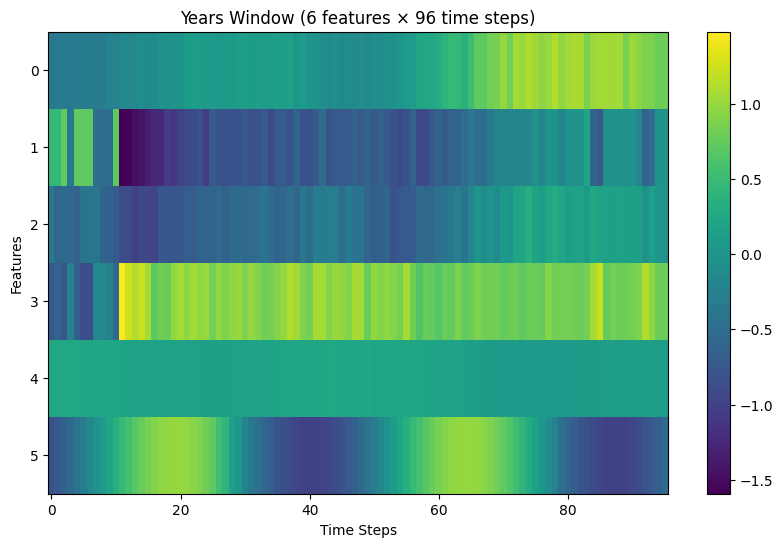

In [8]:
plot_first_window(df_years_norm, window_size=96, title_name="Years")

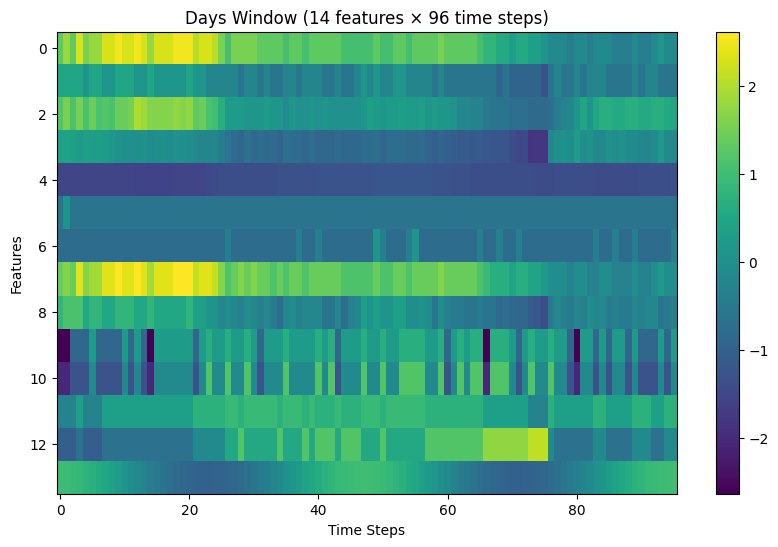

In [9]:
plot_first_window(df_days_norm, window_size=96, title_name="Days")


# Stochastic-PINN - RNN

In [10]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List

In [11]:
# Make sliding windows
def make_sliding_window(df_norm, window_size: int, steps_ahead: int,
                       target_col: str = "WVHT") -> Tuple[np.ndarray, np.ndarray]:
    if len(df_norm) < window_size + steps_ahead + 1:
        raise ValueError(f"Dataframe too short: {len(df_norm)} vs required {window_size + steps_ahead + 1}")

    features = df_norm.to_numpy().astype(np.float32)
    target = df_norm[target_col].to_numpy().astype(np.float32)

    num_windows = len(df_norm) - window_size - steps_ahead
    X = np.zeros((num_windows, window_size, features.shape[1]), dtype=np.float32)
    y = np.zeros(num_windows, dtype=np.float32)

    for i in range(num_windows):
        X[i] = features[i:i+window_size]
        y[i] = target[i+window_size+steps_ahead]

    return X, y

# Make targets
def make_pinn_targets(df_norm, window_size: int, steps_ahead: int) -> np.ndarray:
    if "WVHT" not in df_norm or "DPD" not in df_norm:
        raise ValueError("Missing required columns: WVHT and/or DPD")

    Hs = df_norm["WVHT"].to_numpy().astype(np.float32)
    Tp = df_norm["DPD"].to_numpy().astype(np.float32)

    num_windows = len(df_norm) - window_size - steps_ahead
    Y = np.zeros((num_windows, 2), dtype=np.float32)

    for i in range(num_windows):
        Y[i, 0] = Hs[i+window_size+steps_ahead]
        Y[i, 1] = Tp[i+window_size+steps_ahead]

    return Y

In [12]:
class StochasticWavePINN(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int = 128,
                 num_layers: int = 3, output_dim: int = 2, dropout: float = 0.3):
        super().__init__()

        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )

        self.attention = nn.Linear(hidden_dim * 2, 1)

        # Mean prediction head
        self.fc_mean = nn.Sequential(
            nn.Linear(hidden_dim * 2, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(64, output_dim)
        )

        # Variance/uncertainty head (log-variance for numerical stability)
        self.fc_logvar = nn.Sequential(
            nn.Linear(hidden_dim * 2, 64),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(64, output_dim)
        )

    def forward(self, x, return_uncertainty=False):
        lstm_out, (h, c) = self.lstm(x)
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context = torch.sum(attn_weights * lstm_out, dim=1)

        mean = self.fc_mean(context)
        logvar = self.fc_logvar(context)

        if return_uncertainty:
            return mean, logvar
        return mean, logvar

    def sample(self, x, num_samples=1):
        """Sample from stochastic model using reparameterization trick"""
        mean, logvar = self.forward(x, return_uncertainty=True)
        std = torch.exp(0.5 * logvar)

        samples = []
        for _ in range(num_samples):
            eps = torch.randn_like(std)
            sample = mean + eps * std
            samples.append(sample)

        if num_samples == 1:
            return samples[0]
        return torch.stack(samples)

In [13]:
def physics_ito_sde(pred_mean: torch.Tensor, pred_logvar: torch.Tensor, dt: float = 1.0) -> torch.Tensor:
    """
    Stochastic wave physics using Ito calculus:
    dH_s = μ(H_s, T_p) dt + σ(H_s, T_p) dW_t

    Wave action conservation with stochastic forcing
    """
    Hs_mean = pred_mean[:, 0]
    Tp_mean = pred_mean[:, 1]

    Hs_std = torch.exp(0.5 * pred_logvar[:, 0])
    Tp_std = torch.exp(0.5 * pred_logvar[:, 1])

    # Wave action density N = E/σ ≈ Hs²/Tp
    N_mean = (Hs_mean**2) / (Tp_mean.clamp(min=1e-3) + 1e-6)

    # Ito correction term
    ito_correction = 0.5 * (Hs_std**2) / (Tp_mean.clamp(min=1e-3) + 1e-6)

    if len(N_mean) > 1:
        dN = N_mean[1:] - N_mean[:-1]
        drift_loss = torch.mean(dN**2)
    else:
        drift_loss = torch.tensor(0.0)

    diffusion_loss = torch.mean((Hs_std - 0.1 * Hs_mean.abs())**2)
    diffusion_loss += torch.mean((Tp_std - 0.05 * Tp_mean.abs())**2)

    period_constraint = torch.mean(torch.relu(-Tp_mean + 0.5))
    height_constraint = torch.mean(torch.relu(-Hs_mean))

    # Steepness with uncertainty
    steepness_mean = Hs_mean / (Tp_mean.clamp(min=1e-3) + 1e-6)
    steepness_loss = torch.mean(torch.relu(steepness_mean - 0.5))

    uncertainty_reg = -torch.mean(pred_logvar) * 0.01

    total_phys = (drift_loss +
                  0.1 * diffusion_loss +
                  0.1 * period_constraint +
                  0.1 * height_constraint +
                  0.05 * steepness_loss +
                  uncertainty_reg +
                  0.05 * torch.mean(ito_correction.abs()))

    return total_phys

In [14]:
def gaussian_nll_loss(pred_mean: torch.Tensor, pred_logvar: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    """Negative log-likelihood for Gaussian distribution (heteroscedastic)"""
    variance = torch.exp(pred_logvar)
    nll = 0.5 * (torch.log(2 * np.pi * variance) + (target - pred_mean)**2 / variance)
    return torch.mean(nll)


class EarlyStopping:
    def __init__(self, patience: int = 15, min_delta: float = 1e-5):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss: float) -> bool:
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
        return self.early_stop

In [15]:
def train_stochastic_pinn(
    model: nn.Module,
    X_train: torch.Tensor,
    Y_train: torch.Tensor,
    X_val: torch.Tensor,
    Y_val: torch.Tensor,
    epochs_stage1: int = 250,
    epochs_stage2: int = 250,
    lambda_phys: float = 1e-4,
    lr: float = 1e-4,
    patience: int = 30
) -> Dict[str, List[float]]:

    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        opt, mode='min', factor=0.5, patience=10
    )
    early_stopping = EarlyStopping(patience=patience)

    history = {
        'total': [], 'data': [], 'phys': [], 'val': [],
        'grad_norm': [], 'lr': [], 'uncertainty': []
    }

    best_val_loss = float('inf')
    best_model_state = None

    print("\n" + "="*60)
    print("STAGE 1: Stochastic Data-Only Training")
    print("="*60)

    for epoch in range(epochs_stage1):
        model.train()
        opt.zero_grad()

        pred_mean, pred_logvar = model(X_train)
        data_loss = gaussian_nll_loss(pred_mean, pred_logvar, Y_train)

        data_loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        opt.step()

        model.eval()
        with torch.no_grad():
            val_mean, val_logvar = model(X_val)
            val_loss = gaussian_nll_loss(val_mean, val_logvar, Y_val).item()
            avg_uncertainty = torch.mean(torch.exp(0.5 * val_logvar)).item()

        scheduler.step(val_loss)

        history['total'].append(data_loss.item())
        history['data'].append(data_loss.item())
        history['phys'].append(0.0)
        history['val'].append(val_loss)
        history['grad_norm'].append(grad_norm.item())
        history['lr'].append(opt.param_groups[0]['lr'])
        history['uncertainty'].append(avg_uncertainty)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()

        if epoch % 20 == 0:
            print(f"Epoch {epoch:3d} | Train: {data_loss.item():.5f} | "
                  f"Val: {val_loss:.5f} | σ: {avg_uncertainty:.4f} | "
                  f"Grad: {grad_norm:.3f} | LR: {opt.param_groups[0]['lr']:.2e}")

        if early_stopping(val_loss):
            print(f"Early stopping at epoch {epoch}")
            break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    print("\n" + "="*60)
    print("STAGE 2: Stochastic Physics-Informed Training (Ito SDE)")
    print("="*60)

    opt = torch.optim.AdamW(model.parameters(), lr=lr*0.5, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        opt, mode='min', factor=0.5, patience=10
    )
    early_stopping = EarlyStopping(patience=patience)

    for epoch in range(epochs_stage2):
        model.train()
        opt.zero_grad()

        pred_mean, pred_logvar = model(X_train)
        data_loss = gaussian_nll_loss(pred_mean, pred_logvar, Y_train)
        phys_loss = physics_ito_sde(pred_mean, pred_logvar)

        total_loss = data_loss + lambda_phys * phys_loss

        total_loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        opt.step()

        model.eval()
        with torch.no_grad():
            val_mean, val_logvar = model(X_val)
            val_loss = gaussian_nll_loss(val_mean, val_logvar, Y_val).item()
            avg_uncertainty = torch.mean(torch.exp(0.5 * val_logvar)).item()

        scheduler.step(val_loss)

        history['total'].append(total_loss.item())
        history['data'].append(data_loss.item())
        history['phys'].append(phys_loss.item())
        history['val'].append(val_loss)
        history['grad_norm'].append(grad_norm.item())
        history['lr'].append(opt.param_groups[0]['lr'])
        history['uncertainty'].append(avg_uncertainty)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()

        if epoch % 20 == 0:
            print(f"Epoch {epoch:3d} | Total: {total_loss.item():.5f} | "
                  f"Data: {data_loss.item():.5f} | Phys: {phys_loss.item():.5f} | "
                  f"Val: {val_loss:.5f} | σ: {avg_uncertainty:.4f}")

        if early_stopping(val_loss):
            print(f"Early stopping at epoch {epoch}")
            break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"\nBest val loss: {best_val_loss:.5f}")

    return history

In [16]:
def plot_training_history(history: Dict[str, List[float]], save_path: str = None):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    axes[0, 0].plot(history['data'], label='Train', alpha=0.7)
    axes[0, 0].plot(history['val'], label='Val', alpha=0.7)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Data Loss (NLL)')
    axes[0, 0].legend()
    axes[0, 0].set_yscale('log')
    axes[0, 0].grid(True, alpha=0.3)

    axes[0, 1].plot(history['phys'], color='red', alpha=0.7)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Physics Loss')
    axes[0, 1].set_title('Ito SDE Constraint')
    axes[0, 1].grid(True, alpha=0.3)

    axes[0, 2].plot(history['uncertainty'], color='orange', alpha=0.7)
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('Avg Uncertainty (σ)')
    axes[0, 2].set_title('Predictive Uncertainty')
    axes[0, 2].grid(True, alpha=0.3)

    axes[1, 0].plot(history['grad_norm'], color='green', alpha=0.7)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Gradient Norm')
    axes[1, 0].set_title('Gradient Monitoring')
    axes[1, 0].grid(True, alpha=0.3)

    axes[1, 1].plot(history['lr'], color='purple', alpha=0.7)
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('LR')
    axes[1, 1].set_title('Learning Rate')
    axes[1, 1].set_yscale('log')
    axes[1, 1].grid(True, alpha=0.3)

    axes[1, 2].plot(history['total'], label='Total', alpha=0.7)
    axes[1, 2].plot(history['data'], label='Data', alpha=0.7)
    axes[1, 2].set_xlabel('Epoch')
    axes[1, 2].set_ylabel('Loss')
    axes[1, 2].set_title('Combined Losses')
    axes[1, 2].legend()
    axes[1, 2].set_yscale('log')
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

In [17]:
def plot_predictions_with_uncertainty(model, X_val, Y_val, num_samples=50, save_path=None):
    """Plot predictions with confidence intervals from stochastic model"""
    model.eval()

    # how many points you want on the x-axis
    n = 60

    with torch.no_grad():
        samples = model.sample(X_val[:100], num_samples=num_samples)
        mean_pred = samples.mean(dim=0)
        std_pred = samples.std(dim=0)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Wave Height
    axes[0].plot(Y_val[:100, 0].numpy(), 'k-', label='True', alpha=0.7, linewidth=2)
    axes[0].plot(mean_pred[:, 0].numpy(), 'b-', label='Predicted Mean', linewidth=2)
    axes[0].fill_between(
        range(100),
        (mean_pred[:, 0] - 2*std_pred[:, 0]).numpy(),
        (mean_pred[:, 0] + 2*std_pred[:, 0]).numpy(),
        alpha=0.3,
        label='95% CI'
    )
    axes[0].set_xlabel('Sample')
    axes[0].set_ylabel('Wave Height (m)')
    axes[0].set_title('Wave Height Prediction with Uncertainty')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xlim(0, n)

    # period
    axes[1].plot(Y_val[:100, 1].numpy(), 'k-', label='True', alpha=0.7, linewidth=2)
    axes[1].plot(mean_pred[:, 1].numpy(), 'r-', label='Predicted Mean', linewidth=2)
    axes[1].fill_between(
        range(100),
        (mean_pred[:, 1] - 2*std_pred[:, 1]).numpy(),
        (mean_pred[:, 1] + 2*std_pred[:, 1]).numpy(),
        alpha=0.3,
        color='red',
        label='95% CI'
    )
    axes[1].set_xlabel('Sample')
    axes[1].set_ylabel('Period (s)')
    axes[1].set_title('Wave Period Prediction with Uncertainty')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    axes[1].set_xlim(0, n)

# Main to run everything above!

Stochastic Wave PINN Training (Ito SDE)

[1/6] Loading data...

[2/6] Setting parameters...
  Window: 48, Steps ahead: 144

[3/6] Creating windows...
  X=(4808, 48, 4), Y=(4808, 2)

[4/6] Train/val split...
  Train: 3846, Val: 962

[5/6] Training stochastic model...
  Params: 986,117

STAGE 1: Stochastic Data-Only Training
Epoch   0 | Train: 19.14357 | Val: 15.67228 | σ: 1.0063 | Grad: 33.031 | LR: 1.00e-03
Epoch  20 | Train: 2.22477 | Val: 2.11769 | σ: 4.6696 | Grad: 2.644 | LR: 1.00e-03
Epoch  40 | Train: 1.82385 | Val: 1.68184 | σ: 2.2387 | Grad: 1.482 | LR: 1.00e-03
Epoch  60 | Train: 1.36992 | Val: 1.01397 | σ: 0.9717 | Grad: 2.556 | LR: 1.00e-03
Epoch  80 | Train: 1.27395 | Val: 0.98371 | σ: 0.9349 | Grad: 0.640 | LR: 1.00e-03
Epoch 100 | Train: 1.23925 | Val: 0.97360 | σ: 0.9108 | Grad: 0.524 | LR: 1.00e-03
Early stopping at epoch 110

STAGE 2: Stochastic Physics-Informed Training (Ito SDE)
Epoch   0 | Total: 1.23751 | Data: 1.23740 | Phys: 0.11297 | Val: 0.96187 | σ: 0.8918
Epo

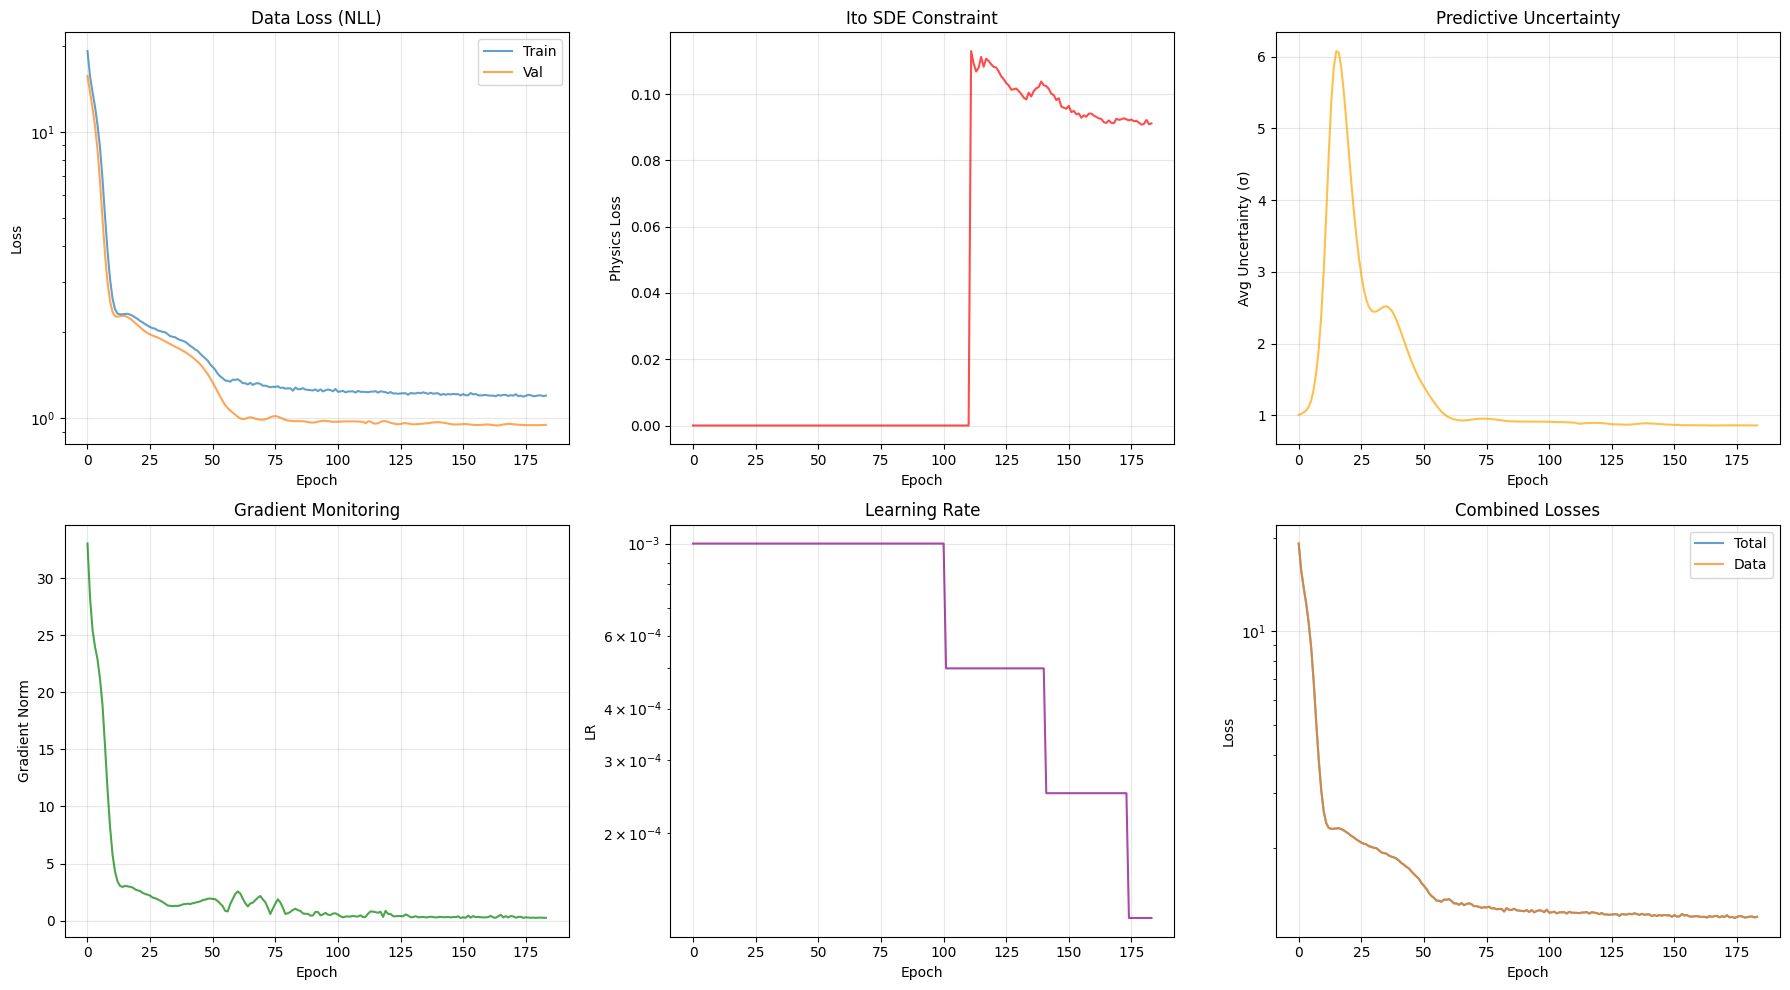

  Training plot: stochastic_training.png
  Predictions plot: uncertainty_predictions.png

Stochastic predictions with uncertainty:
  1. Hs: 1.849±0.623m (true: 2.802m)
      Tp: 7.75±1.26s (true: 8.32s)
  2. Hs: 1.952±0.597m (true: 1.989m)
      Tp: 7.71±1.37s (true: 8.05s)
  3. Hs: 1.861±0.554m (true: 2.066m)
      Tp: 7.55±1.12s (true: 7.68s)
  4. Hs: 1.806±0.555m (true: 2.031m)
      Tp: 7.90±1.14s (true: 7.75s)
  5. Hs: 1.874±0.634m (true: 2.184m)
      Tp: 7.84±1.11s (true: 8.35s)

Done!


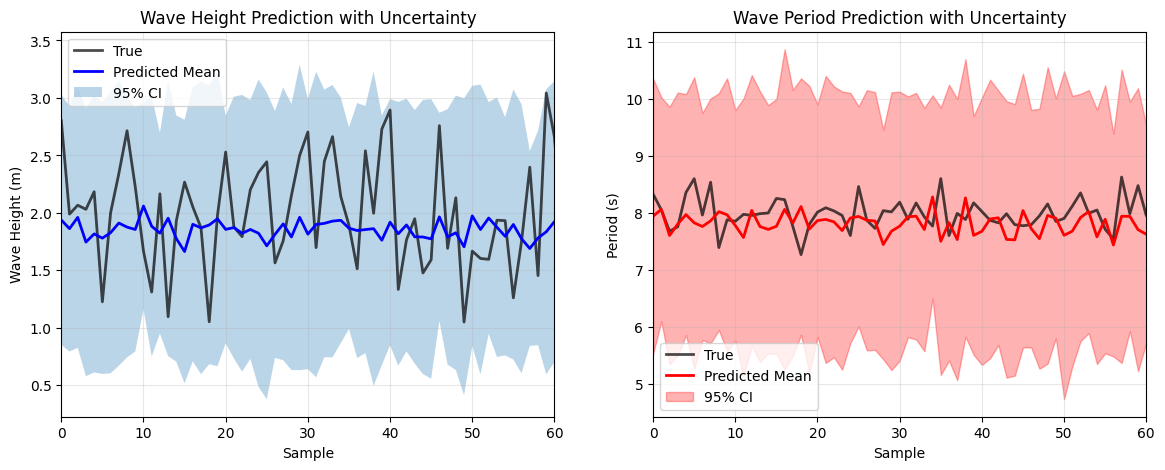

In [22]:
if __name__ == "__main__":
    print("Stochastic Wave PINN Training (Ito SDE)")
    print("=" * 60)

    print("\n[1/6] Loading data...")

    np.random.seed(1)
    n_samples = 5000
    df_years_norm = pd.DataFrame({
        'WVHT': np.random.randn(n_samples) * 0.5 + 2.0,
        'DPD': np.random.randn(n_samples) * 0.3 + 8.0,
        'feature1': np.random.randn(n_samples),
        'feature2': np.random.randn(n_samples),
    })
    df_days_norm = df_years_norm.copy()

    print("\n[2/6] Setting parameters...")
    window_size = 48
    steps_ahead = 48 * 3
    print(f"  Window: {window_size}, Steps ahead: {steps_ahead}")

    print("\n[3/6] Creating windows...")
    X_years, _ = make_sliding_window(df_years_norm, window_size, steps_ahead)
    Y_years = make_pinn_targets(df_years_norm, window_size, steps_ahead)

    print(f"  X={X_years.shape}, Y={Y_years.shape}")

    print("\n[4/6] Train/val split...")
    X_train, X_val, Y_train, Y_val = train_test_split(
        X_years, Y_years, test_size=0.2, shuffle=False
    )

    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    Y_train_t = torch.tensor(Y_train, dtype=torch.float32)
    X_val_t = torch.tensor(X_val, dtype=torch.float32)
    Y_val_t = torch.tensor(Y_val, dtype=torch.float32)

    print(f"  Train: {X_train_t.shape[0]}, Val: {X_val_t.shape[0]}")

    print("\n[5/6] Training stochastic model...")
    model = StochasticWavePINN(
        input_dim=X_train.shape[2],
        hidden_dim=128,
        num_layers=3,
        dropout=0.3
    )
    print(f"  Params: {sum(p.numel() for p in model.parameters()):,}")

    history = train_stochastic_pinn(
        model,
        X_train_t, Y_train_t,
        X_val_t, Y_val_t,
        epochs_stage1=150,
        epochs_stage2=150,
        lambda_phys=1e-3,
        lr=1e-3,
        patience=20
    )

    print("\n[6/6] Saving...")
    torch.save(model.state_dict(), 'stochastic_wave_pinn.pt')
    print("  Model: stochastic_wave_pinn.pt")

    plot_training_history(history, save_path='stochastic_training.png')
    print("  Training plot: stochastic_training.png")

    plot_predictions_with_uncertainty(model, X_val_t, Y_val_t, save_path='uncertainty_predictions.png')
    print("  Predictions plot: uncertainty_predictions.png")

    print("\nStochastic predictions with uncertainty:")
    model.eval()
    with torch.no_grad():
        samples = model.sample(X_val_t[:5], num_samples=100)
        mean_samples = samples.mean(dim=0)
        std_samples = samples.std(dim=0)

        for i in range(5):
            pred_hs_mean = mean_samples[i, 0].item()
            pred_hs_std = std_samples[i, 0].item()
            pred_tp_mean = mean_samples[i, 1].item()
            pred_tp_std = std_samples[i, 1].item()
            true_hs, true_tp = Y_val_t[i].numpy()

            print(f"  {i+1}. Hs: {pred_hs_mean:.3f}±{pred_hs_std:.3f}m (true: {true_hs:.3f}m)")
            print(f"      Tp: {pred_tp_mean:.2f}±{pred_tp_std:.2f}s (true: {true_tp:.2f}s)")

    print("\n" + "="*60)
    print("Done!")
    print("="*60)